## Risk Factor Model Construction with Regression

This is a simple notebook that goes through the process of constructing a simple factor model with some sample data using regression.

Suppose we have some data (supplied in "risk factors.xlsx"). Our objective is to build a simple risk factor model to explain the risk attribution of a return series.
The sheet labeled "Target" contains a time series vector that we would like to explain, and the “factors” and/or “etf-returns” sheets are potential risk factors.

My approach is to fit a multiple linear regression of the etfs, factors, or both the etfs and factors to the return series. The models' variables (etfs and/or factors) serve as the factors in the factor model, and the coefficients to these factors serve as a proxy to the proportion that each one of those factors plays in modeling the variance.

*This notebook assumes the reader is familiar with basic and advanced regression concepts.*

First, some exploratory analysis. What are we dealing with here?

It helps to open up the excel spreadsheet and take a look, as well as to plot some of the data.

Upon opening up the excel document, we notice that there is a date mismatch. It is not unheard of to have an extended time series, i.e. of a greater length for the predictors or independent variables, and a shorter time series for your response variable (or dependent variable). This is typically done when trying to use a historical period of time to compute one or more statistics that are relevant to the response variable.

However, in this data set, the response had a larger vector length, starting from 2010, while the independent variables had data only from 2018 onward. This is unusual. It could be caused for a variety of reasons. Perhaps the data was provided by an external data provider "as-is." Perhaps the data was generated by querying a table, and the date ranges weren't aligned. Regardless, we need to figure out what to do here. One option is to go out and find data for 2010-2018 for the predictors, and then prepend that to the given data. However, this could result in issues if different data providers submit their own, differing quotes. For exchange data this doesn't happen, but I am less familiar with macroeconomic data. Thus, I will restrict the data analysis period to 2018 to 2020.



Having familiarized myself with the data, some ideas immediately came to mind:
1. Regress the four ETFs onto the target returns to see if the target return could be explained by the ETF returns
2. Regress the three macroeconomic factors onto the target returns to see if the target return could be explained by the factors.
3. Regress the four ETFs and the three factors onto the target.
4. Regress an intelligently-chosen subset of the four ETFs and three factors onto the target.
5. Perform a principal component analysis on the ETFs, and then perform a regression with the principal components as the dependent variables.

In [5]:
#For running as a script, include this line
#!usr/bin/env python3


#Step 0: Import Libraries

import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Version 1.4.2 on my system, versions 0.x will result in problems
import pandas as pd
import matplotlib.pyplot as plt


In [6]:
#Step 1: Load Data, and clean it up

target_returns = pd.read_excel("risk factors.xlsx", sheet_name = "Target")
target_returns.rename( columns = {'endDate': 'date'}, inplace=True)
etf_returns = pd.read_excel("risk factors.xlsx", sheet_name = "etf-returns")
factors = pd.read_excel("risk factors.xlsx", sheet_name = "factors")
factors.rename( columns = {'Unnamed: 0': 'date'}, inplace=True)
predictions = pd.merge(etf_returns, factors)

Data = pd.merge(target_returns, predictions)
#get rid of missing values
Data.dropna(inplace=True)
#finally, scale units so that everything is in percent
Data['united-states-ig-oas-all-sector'] /= 100
Data['united-states-hy-oas-all-sector'] /= 100
#To have a copy of cleaned data
Data.to_csv("Data.csv", index=False)

In [10]:

#Step 2: Perform analysis - ETF Only Model
num_samples , c = Data.shape

y = Data['returns']
x = Data[['dbc', 'hyg', 'ief', 'spy']]
# #Very important: statsmodels by default does not assume that an intercept exists. We need to perform the following function call:
x = sm.add_constant(x)
etf_only_model = sm.OLS(y, x).fit()
print(etf_only_model.summary())


                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     223.1
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          3.92e-125
Time:                        22:11:55   Log-Likelihood:                 3521.3
No. Observations:                 737   AIC:                            -7033.
Df Residuals:                     732   BIC:                            -7010.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.438e-05   7.57e-05      1.115      0.2

Let's take a few minutes to analyze the results of this regression. First, with an adjusted R squared of 0.547, there seems to be a moderate relationship between the ETF data and the target returns. In percentage terms, the R-squared value, 54.9%, means that our model explains 54.9% of the change in our dependent variable.

We need to be careful though. With linear regression, as we add more variables, the R-squared value will be nondecreasing. So we could see a model that appears to be more accurate with additional variables, but those added variables could be poor contributors to the model. Thus, we don't use the R-squared value, but instead the adjusted R-squared value, which is 54.7% in this case. This is minor for this model since there are only 4 variables, but as we move forward with our analysis, we will likely see more of a difference between the two values.

The F-stat aims to determine if the chosen group of variables are statistically significnat. It does this by comparing this model against a model where the variables' effect is zeroed out. The probability here is infinitesimally small, which is a good thing. This means that setting our variables to zero does not make sense, i.e., they are statistically significant.

Lastly, we want to pay attention to AIC and BIC, the Akaike and Bayesian information criterion, respectively. These numbers are critertion for model selection, and generally speaking, the lower the number, the better. These two numbers are very important for model selection. The reason we consider both and not just one is because AIC has a slight tendency to choose too large of a model, and BIC has a slight tendency to choose too small of a model. If you find out about a "goldilocks" information criterion, let me know!

Let's also consider some plots associated with the model.

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


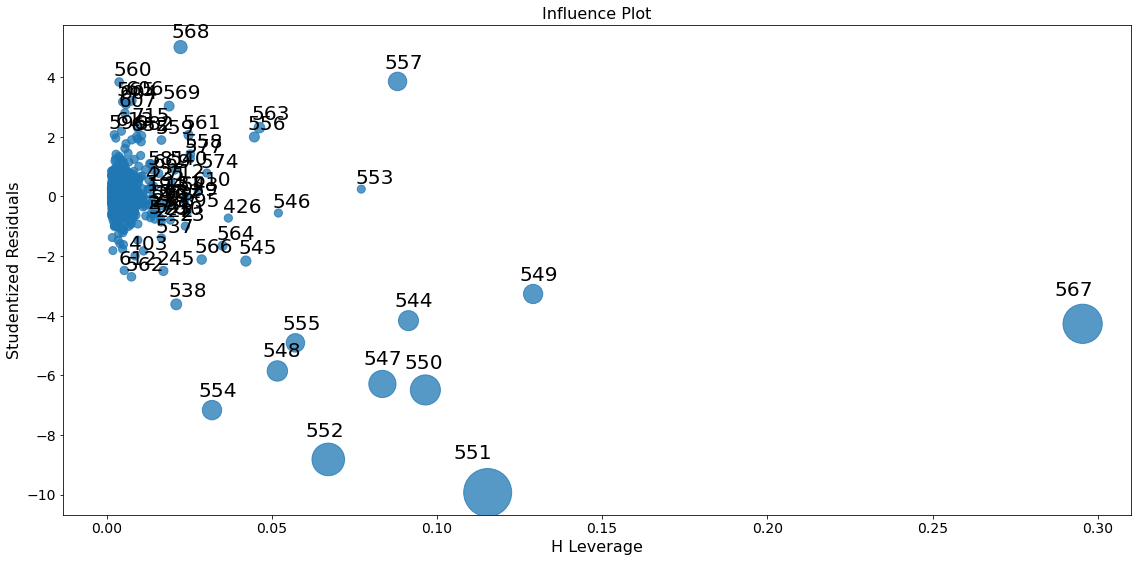

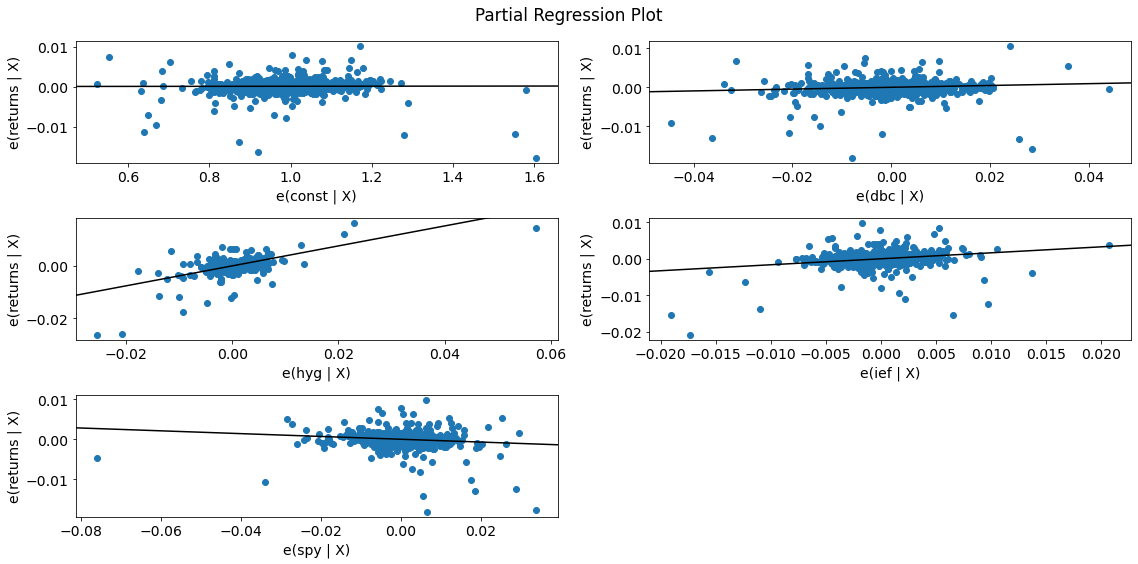

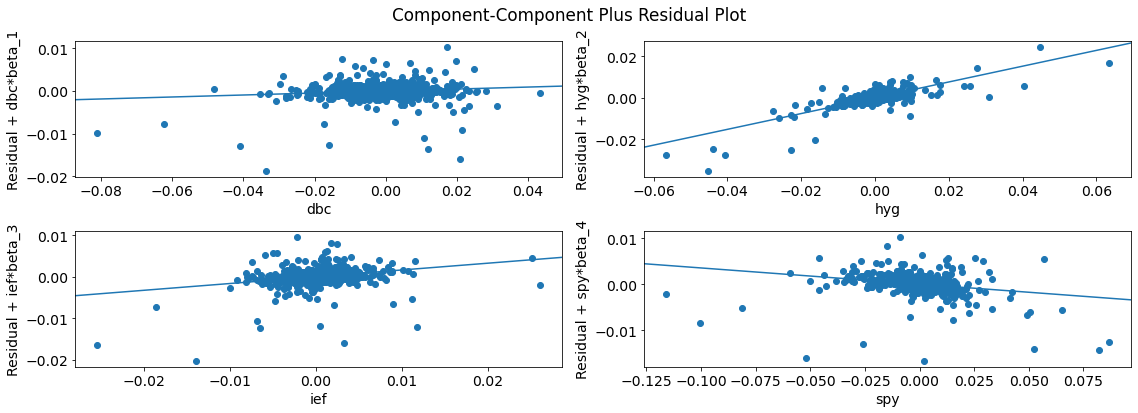

In [11]:

#Model 1: ETFs only. Influence Plots
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)
fig = sm.graphics.influence_plot(etf_only_model, criterion="cooks")
fig.tight_layout(pad=1.0)
plt.savefig('etf_only_influence.png', dpi = 600)

fig = sm.graphics.plot_partregress_grid(etf_only_model)
fig.tight_layout(pad=1.0)
plt.savefig('etf_only_partregress.png', dpi = 600)

fig = sm.graphics.plot_ccpr_grid(etf_only_model)
fig.tight_layout(pad=1.0)
plt.savefig('etf_only_ccpr_grid.png', dpi = 600)

### Model 1, Plot Analysis 

#### Influence

The first plot is the influence plot. This is actually quite a high-level plot. It plots the leverage of the data against the studentized residuals. Studentizing the residuals is a process where they are scaled with respect to their error, and that particular data points' value is not included when computing its deviance from the least squares regression line. It is considered the best type of residual to use.

Leverage is a measure of an observations effect on the results. If a single point is an extreme value, or has a strong influence on the results, it is said to have a *high leverage.*

Thus, the influence plot tells us precisely how much influence any given data point has on the results of the regression. What we see is that data point 567 has the highest leverage for a residual value of -4, which would be considered an extreme outlier. In addition, many values in the 500s seem to all be higher than normal leverage. This suggests that around that index, something unusual happened compared to the other points in time. What's likely is that we experienced a period of sharp volatility, given that time-series data, particularly stock return data, exhibits volatility clustering.

In fact, if we open the original data set, and look at the index, we will see that the row 545 in excel (which would be index 543 for our pandas dataframe) is March 2nd, 2020. These extreme values represent the COVID crash.

High leverage points by themselves are not toxic to a model. They are simply a potential problem. For this exercise, I think to use a linear model, it would be better to have one for before COVID, and one for after. Remember that when the COVID crash occurred, a lot of models failed. (Remember negative oil prices?)

We won't make any other changes to our original dataset. We'll simply analyze the models performance.

#### Partial Regression Plots

Since we are performing a multivariate regression, it is inappropriate to look solely at individual bivariate plots to identify the type of relationship between the response and predictor. A partial regression plot shows us the relationship of the dependent variable and one independent variable, conditioned on all other independent variables. These plots simply tell us can we make any predictions on the expectation of the dependent variable. The lines we see in these plots are not lines of best fit. They are residual lines.

These plots are not great, so we prefer to use Component Component Plus Regression Plots, which improve upon this.


#### Component Component Plus Regression (CCPR) Regression Plots

CCPR plots are an extesnion of partial residual plots. These plots add a line indicating where the line of best fit lies. Significant deviance between the line of best fit in a CCPR plot compared to the slope of the line in the partial regression plot suggests that this particular predictor does not have a linear relationship with the dependent variable.


Visually, at a glance, the subplots are similar enough.